In [46]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCELoss,  Dropout, Sequential, Sigmoid, Dropout, BatchNorm1d, Conv2d,MaxPool2d, BatchNorm2d


In [47]:
data=pd.read_csv('Dataset/updated_emergency_classification.csv')
seed=42

In [48]:
X=[]
for img_name in data.image_name:
    # print(img_name)
    img=plt.imread('Dataset\Dataset\Images/'+img_name)
    img=img/255.0
    X.append(img)

X=np.array(X)
y=data['emergency_or_not'].values

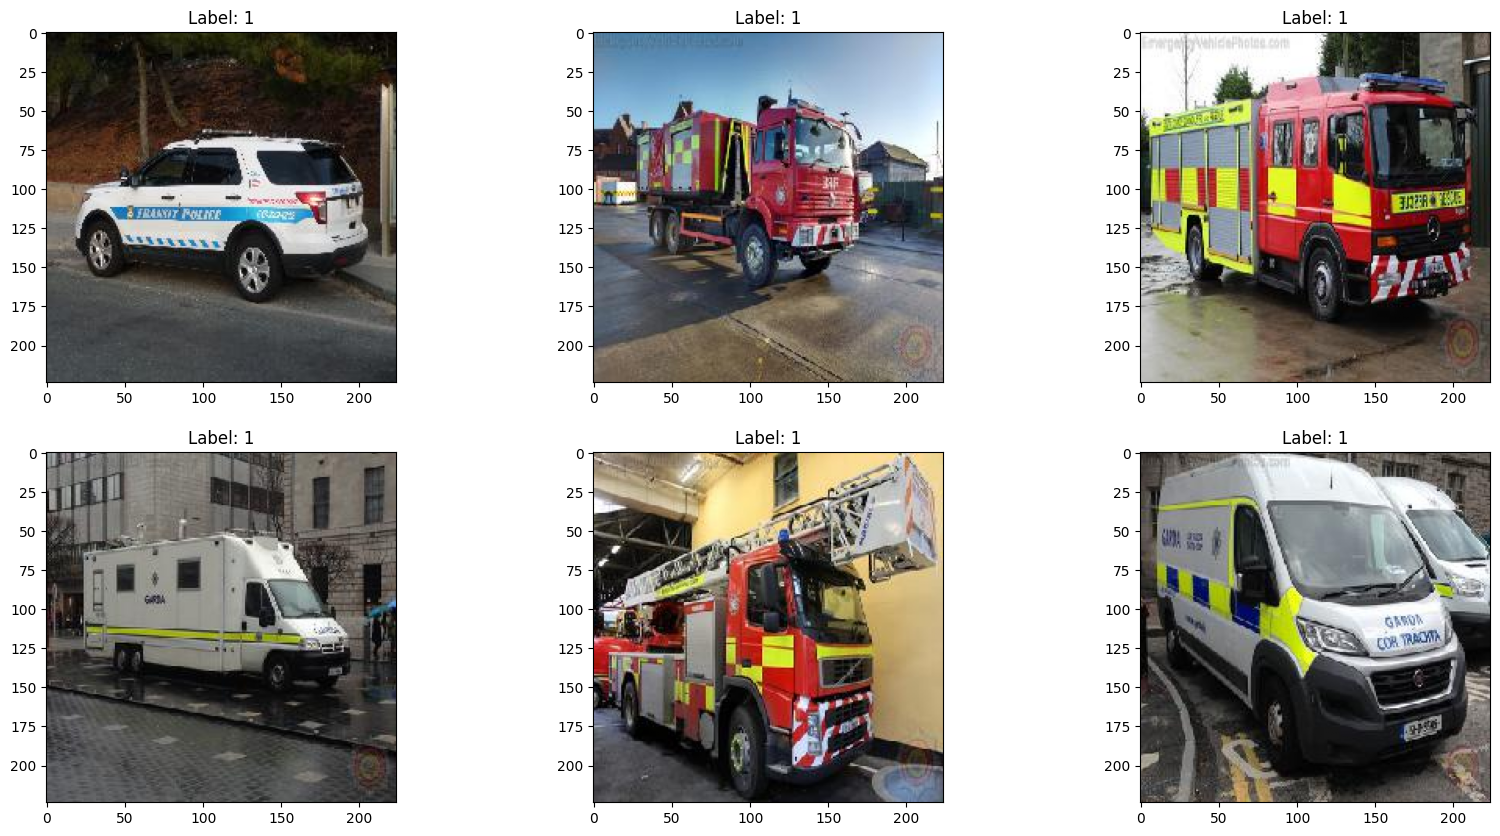

In [49]:
fig, ax= plt.subplots(2,3, figsize=(20,10))
for i in range(6):
    ax[i//3][i%3].imshow(X[i])
    ax[i//3][i%3].set_title(f'Label: {y[i]}')
plt.show()

In [50]:
X=np.moveaxis(X, -1, 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1587, 3, 224, 224), (1587,), (681, 3, 224, 224), (681,))

In [51]:
X_train=torch.FloatTensor(X_train)
y_train=torch.FloatTensor(y_train)
X_valid=torch.FloatTensor(X_valid)  
y_valid=torch.FloatTensor(y_valid)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(torch.Size([1587, 3, 224, 224]),
 torch.Size([1587]),
 torch.Size([681, 3, 224, 224]),
 torch.Size([681]))

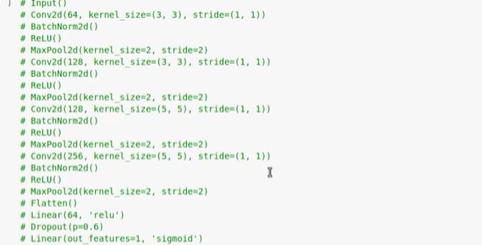

Work out the input output channels for each step as done here to enure you  get the architecture right.

In [52]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional Block 1
        self.conv_layers = Sequential(
            Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(64),    #64,222,222
            ReLU(),
            MaxPool2d(2,2),     #64,111,111
            Conv2d(64,128,3),   #128,109,109
            BatchNorm2d(128),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),     #128*54*54
            Conv2d(128,128,5),                      #128,50,50
            BatchNorm2d(128),
            ReLU(),
            MaxPool2d(2,2) ,                         #256,25,25
            Conv2d(128,256,5),                      #256,21,21
            BatchNorm2d(256),
            ReLU(),
            MaxPool2d(2,2)                          #256,10,10
        )

        self.Linear_layers = Sequential(
            Linear(10*10*256,64),
            ReLU(),
            Dropout(0.6),
            Linear(64,1),
            Sigmoid()
        )

    def forward(self, x):
        x=self.conv_layers(x)
        # print(x.size(0))
        x=x.reshape(x.size(0),-1) #Flattening
        x=self.Linear_layers(x)
        return x

Print the model to reviee the architecture to make sure it aligns with the intended design

In [53]:
torch.manual_seed(32)
model= Net()


# Defining optimizer and loss
optimizer=Adam(model.parameters(), lr=0.001)
criterion= nn.BCELoss()

if torch.cuda.is_available():
    model=model.cuda()
    criterion=criterion.cuda()

print(model)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, p

Testing for a single input image before running it on the whole thing to make sure you've got the Architecture right.


In [54]:
model(X_train[0].view(1,3,224,224)).item()

0.5534390211105347

In [55]:
# define metric
def binary_accuracy(y_pred, y_true):
    y_pred_tag = torch.round(y_pred)  # Round predictions to the closest integer
    correct_results_sum = (y_pred_tag == y_true).sum().float()  # Convert into float for division 
    acc = correct_results_sum / y_true.shape[0]  # Calculate accuracy
    acc = torch.round(acc * 100)  # Convert to percentage
    return acc

In [56]:
# define training function
def train(X, y, batch_size):
    model.train()
    epoch_loss=0
    epoch_acc=0
    no_of_batches=0
    indices=torch.randperm(X.shape[0])
    for i in tqdm(range(0,X.shape[0],batch_size)):
        no_of_batches+=1
        batch_indices=indices[i:i+batch_size]
        batch_X=X[batch_indices]
        batch_y=y[batch_indices]
        
        if torch.cuda.is_available():
            batch_X=batch_X.cuda()
            batch_y=batch_y.cuda()

        y_pred=model(batch_X)
        loss=criterion(y_pred,batch_y.view(-1,1))

        acc=binary_accuracy(y_pred,batch_y.view(-1,1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
    return epoch_loss/no_of_batches, epoch_acc/no_of_batches

In [57]:
def evaluate(X, y, batch_size):
    model.eval()
    epoch_loss=0
    epoch_acc=0
    no_of_batches=0
    indices=torch.randperm(X.shape[0])
    with torch.no_grad():
        for i in tqdm(range(0,X.shape[0],batch_size)):
            no_of_batches+=1
            batch_indices=indices[i:i+batch_size]
            batch_X=X[batch_indices]
            batch_y=y[batch_indices]

            if torch.cuda.is_available():
                batch_X=batch_X.cuda()
                batch_y=batch_y.cuda()
                

            output=model(batch_X) 
            output=output.squeeze(1)
            print(output)
            loss=criterion(output,batch_y.view(-1,1))

            acc=binary_accuracy(output,batch_y.view(-1,1))

            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/no_of_batches, epoch_acc/no_of_batches

In [58]:
def predict(X, batch_size):
    model.eval()
    predictions=[]
    indices=torch.randperm(X.shape[0])
    with torch.no_grad():
        for i in tqdm(range(0,X.shape[0],batch_size)):
            no_of_batches+=1
            batch_indices=indices[i:i+batch_size]
            batch_X=X[batch_indices]
           

            if torch.cuda.is_available():
                batch_X=batch_X.cuda()
               
                output=model(batch_X.data.cpu().numpy())
            else:
                output=model(batch_X.numpy())        
            # output=output.squeeze()   
            prediction=output.numpy() 
            predictions.append(prediction)
    predictions=np.concatenate(predictions,axis=0)
           
    return predictions

In [59]:
N_EPOCHS=10
batch_size=32
best_valid_acc=0

for epoch in range(N_EPOCHS):
    train_loss, train_acc=train(X_train,y_train,batch_size)
    valid_loss, valid_acc=evaluate(X_valid,y_valid,batch_size)

    

    if valid_acc>best_valid_acc:
        best_valid_acc=valid_acc
        torch.save(model.state_dict(), 'model.pt')

    print(f'Epoch {epoch+1}/{N_EPOCHS}')
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc:.2f}%')


  0%|          | 0/22 [00:01<?, ?it/s]

tensor([0.2758, 0.3020, 0.5544, 0.5635, 0.1875, 0.2814, 0.2905, 0.2893, 0.3957,
        0.2751, 0.5232, 0.5521, 0.5854, 0.3206, 0.5548, 0.2997, 0.5773, 0.1113,
        0.2053, 0.6053, 0.4250, 0.5227, 0.4891, 0.2466, 0.2994, 0.1939, 0.5551,
        0.4243, 0.2302, 0.4804, 0.5129, 0.4993])


ValueError: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])) is deprecated. Please ensure they have the same size.

In [ ]:
path='model.pt'
model.load_state_dict(torch.load(path))

In [ ]:
train_loss, train_acc=evaluate(X_train,y_train,batch_size)
valid_loss,valid_acc=evaluate(X_valid,y_valid,batch_size)
print("Final Training accuracy: ",(train_acc)*100)
print("Final Validation accuracy: ",(valid_acc)*100)

In [ ]:
predictions=predict(X_valid,batch_size)

In [ ]:
# Print first 5 predictions

print("First 5 predictions: ", predictions[:5])
